# Classification. Linear models and KNN

In [40]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [313]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder,PolynomialFeatures
from sklearn.feature_selection import  SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.impute import SimpleImputer


## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [42]:
from sklearn.exceptions import NotFittedError

In [43]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_arr = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        sig = 1 / (1 + np.exp(-X @ weights))
        return sig
        
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        r = (1 / (2 * self.C)) * np.linalg.norm(weights)
        #r = 1/(2*self.C)*np.linalg.norm(self.weights_)**2
        loss = np.log(1 + np.exp(-(weights @ x.T) * y)).mean() + r
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            delta = -(X_ext.T @ (y * (1 - 1 / (1 + np.exp(-(self.weights_ @ X_ext.T) * y))))) / len(y) + self.weights_ / self.C
            self.weights_ -= self.eta * delta
            self.loss_arr.append(self.get_loss(X_ext, self.weights_,y))
            if np.linalg.norm(delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        return np.where(self.predict_proba(X) >= 0.5, 1, -1)

In [44]:
from sklearn import datasets
from sklearn import metrics

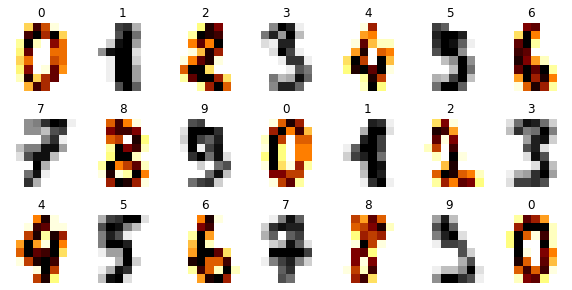

In [45]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [46]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [47]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [48]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [49]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [50]:
lr_clf.fit(X_train, y_train)

In [51]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [52]:
model = CustomLogisticRegression()

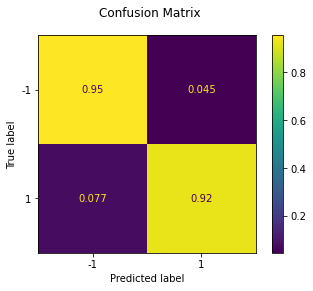

In [53]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [54]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [55]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

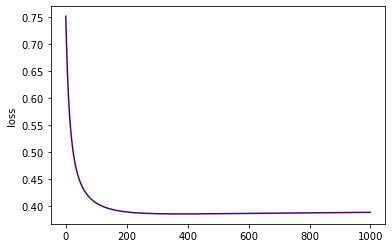

In [56]:
## your code
plt.plot(model.loss_arr,color = 'indigo');
plt.ylabel('loss')
plt.show()



**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

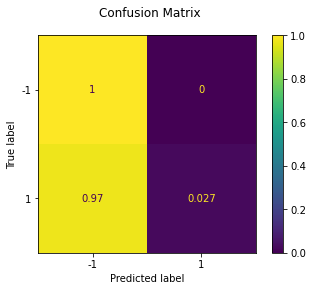

eta = 0.12


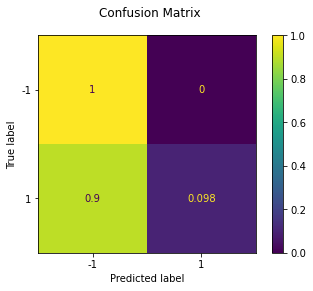

eta = 0.0606


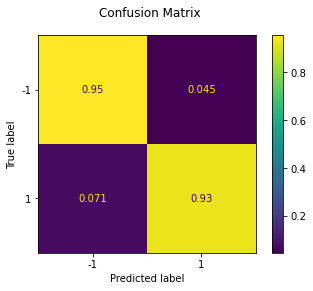

eta = 0.0012


In [115]:
## your code
# dif_learn = CustomLogisticRegression(eta=0.10)
# fit_evaluate(dif_learn, X_train, y_train, X_test, y_test)
#Выбор слишком малого значения приводит к более медленной сходимости. 
#Выбор слишком большого значения может привести к перешагиванию через минимум и расхождению.

etas = np.linspace(0.12,0.0012,3)

for eta in etas:
    
    dif_learn = CustomLogisticRegression(eta)
    fit_evaluate(dif_learn, X_train, y_train, X_test, y_test)
    print('eta =', eta )
    
    


< your thoughts >

**(0.5 points)** Try different regularization parameter values and compare the model quality.

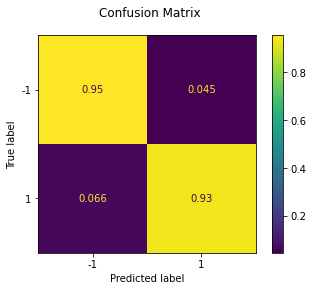

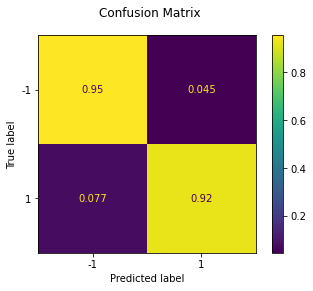

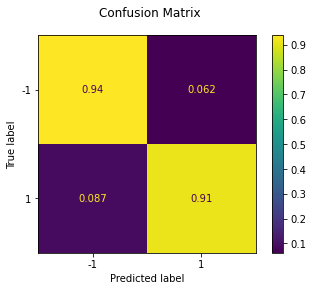

(0.9025748086290883, 0.925)

In [120]:
## your code
reg_param = CustomLogisticRegression(C = 4)
fit_evaluate(reg_param, X_train, y_train, X_test, y_test)
reg_param = CustomLogisticRegression(C = 1)
fit_evaluate(reg_param, X_train, y_train, X_test, y_test)
reg_param = CustomLogisticRegression(C = 0.4)
fit_evaluate(reg_param, X_train, y_train, X_test, y_test)
#Регуляризация обычно пытается уменьшить сложность модели или снизить ее
#C — положительное число с плавающей запятой (1.0 по умолчанию), 
#которое определяет относительную силу регуляризации. Меньшие значения указывают на более сильную регуляризацию.
#большее значение C означает более слабую регуляризацию


< your thoughts >

**(0.5 points)** Compare zero initialization and random initialization. 

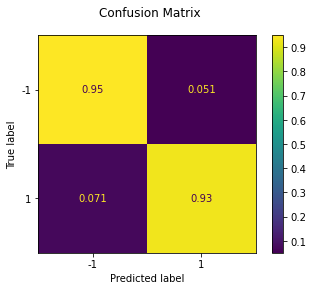

(0.9116214335421016, 0.9388888888888889)

In [123]:
## your code
zero_init = CustomLogisticRegression(zero_init=True)
fit_evaluate(zero_init, X_train, y_train, X_test, y_test)

< your thoughts >

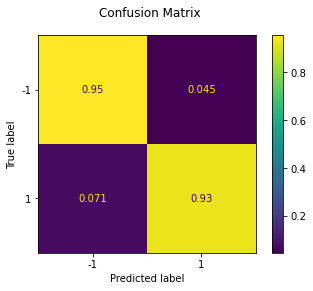

(0.9116214335421016, 0.9416666666666667)

In [127]:
rand_init = CustomLogisticRegression(random_state = 0)
fit_evaluate(rand_init, X_train, y_train, X_test, y_test)

In [ ]:
#если весовые коэффициенты равны 0,прогнозы будут ничем не лучше случайных
#Присвоение случайных значений весам лучше, чем просто присвоение 0

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [302]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
       
        return np.sqrt(((np.expand_dims(X, 0) - np.expand_dims(Y, 1))**2).sum(axis=-1)).T
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        weight = []
        for i in self.classes_:
            count = 0
            for j in range(len(y)):
                if y[j] == i:
                    count += weights[j]
            weight.append(count)
        return weight
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            pointr = P.argsort(axis=1)[:, :self.n_neighbors]
            min_dist = P[np.arange(P.shape[0])[:,None], pointr]
            nam = self.y[pointr]
            weights_ = np.ones(nam.shape)
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / np.maximum(min_dist, self.eps)
            sum_nam = np.array([self.get_class_weights(nam[i], weights_[i]) for i in range(len(P))])
            
            return np.array(sum_nam / np.expand_dims(sum_nam.sum(axis=1), 1))
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        
        return self.predict_proba(X).argmax(axis=1)

In [303]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [304]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [305]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

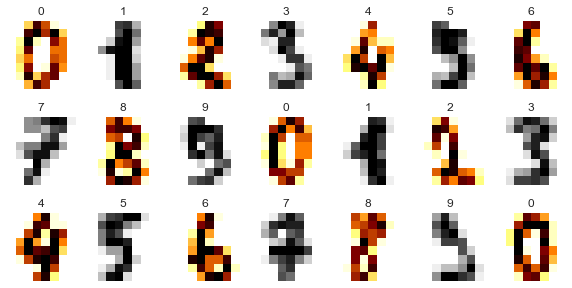

In [273]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [306]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [307]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

AssertionError: 

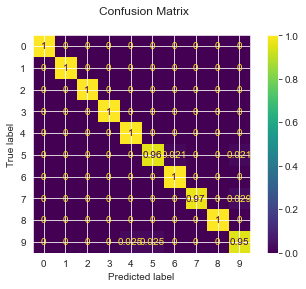

In [256]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Возникают ошибки, Цифры рядом друг с другом: 5 и 6 , 7,9

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

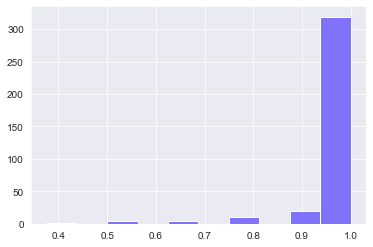

In [291]:
model = CustomKNeighborsClassifier(n_neighbors=8, weights='distance')
model.fit(X_train, y_train)
trym = model.predict_proba(X_test)
plt.hist(trym.max(axis=1));



In [292]:
print(trym.max(axis=1).min(), trym.max(axis=1).max())


0.375 1.0


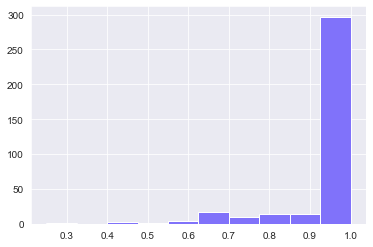

In [294]:
model = CustomKNeighborsClassifier(n_neighbors=16, weights='distance')
model.fit(X_train, y_train)
trym = model.predict_proba(X_test)

plt.hist(trym.max(axis=1));

In [295]:
print(trym.max(axis=1).min(), trym.max(axis=1).max())

0.25 1.0


0.5 1.0


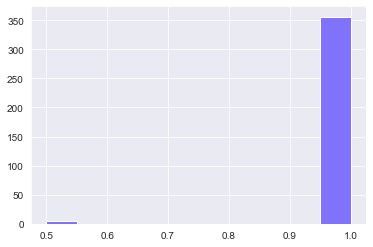

In [297]:
model = CustomKNeighborsClassifier(n_neighbors=2, weights='distance')
model.fit(X_train, y_train)
trym = model.predict_proba(X_test)

plt.hist(trym.max(axis=1))
print(trym.max(axis=1).min(), trym.max(axis=1).max());

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

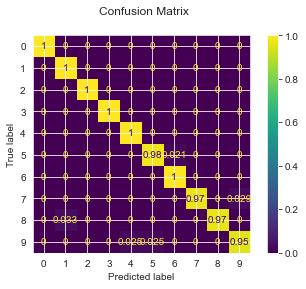

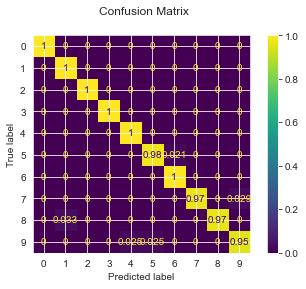

In [301]:
## your code
KNN= KNeighborsClassifier(n_neighbors=8, weights='uniform')
fit_evaluate(knn, X_train, y_train, X_test, y_test);

KNN = KNeighborsClassifier(n_neighbors=8, weights='distance')
fit_evaluate(knn, X_train, y_train, X_test, y_test);

Лучше использовать "равномерные" веса.

weights: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера)

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [149]:
#PATH = "./data/"
PATH = r'C:\Users\aveac\ml'


In [203]:
data = pd.read_csv(os.path.join(PATH,  'train.csv')).set_index('PassengerId')
test = pd.read_csv(os.path.join(PATH,  'test.csv')).set_index('PassengerId')

In [151]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [169]:
## your code
#Сколько женщин и мужчин в наборе данных? 
data.Sex.value_counts()



male      56114
female    43886
Name: Sex, dtype: int64

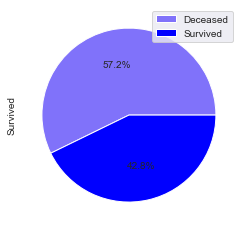

In [171]:
#А как насчет выживших пассажиров? 
# Процент выживших(Survived) и погибших(Deceased),круговая диаграмма

plt.figure(figsize=(6,4))
sns.set_palette(["#8072fa","blue"])

data['Survived'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%')

plt.legend(labels=['Deceased', 'Survived'])
plt.show()

In [172]:
data.Survived.value_counts()

0    57226
1    42774
Name: Survived, dtype: int64

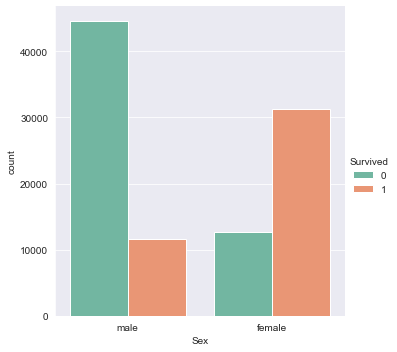

In [154]:
#Существует ли какая-либо связь между полом и выживанием?
sns.set_style("darkgrid")
sns.catplot(x = 'Sex',data=data, hue='Survived',kind = 'count',palette  ='Set2')
# количество выживших мужчин намного меньше ,чем выживших женщин
#1 вывод: если ты мужчина на Synthanic, вероятность что ты умрешь, гораздо больше

< your thoughts >

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

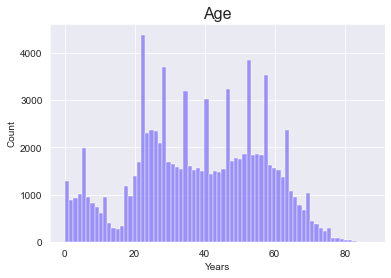

In [182]:
## your code
#Постройте график распределения пассажиров по возрасту. Каков средний и средний возраст выживших и умерших пассажиров? 
#Различается ли распределение по возрасту выживших и умерших пассажиров? Почему?
sns.histplot(data['Age'])
plt.title('Age', fontsize=16)
plt.xlabel('Years')
plt.show()


есть некоторые пики в районе 8, 25 и 55 лет. 

In [188]:
print('Средний возраст',data['Age'].mean())
data['Age'].describe()

Средний возраст 38.35547214294576


count    96708.000000
mean        38.355472
std         18.313556
min          0.080000
25%         25.000000
50%         39.000000
75%         53.000000
max         87.000000
Name: Age, dtype: float64

Mean for survived: 40.55
Mean for deceased: 36.71
Median for survived: 43.00
Median for deceased: 36.00


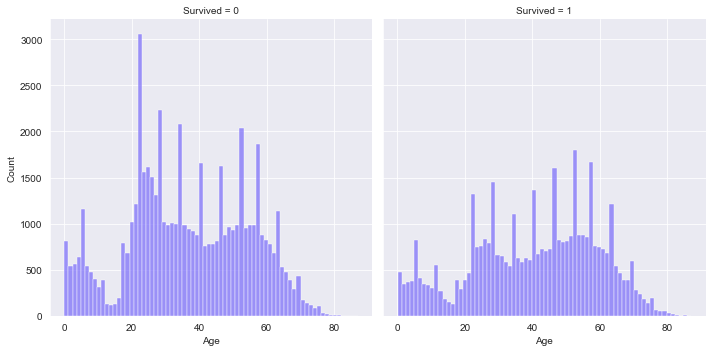

In [191]:
print(f'Mean for survived: {data[data["Survived"] == 1]["Age"].mean():.2f}')
print(f'Mean for deceased: {data[data["Survived"] == 0]["Age"].mean():.2f}')
print(f'Median for survived: {data[data["Survived"] == 1]["Age"].median():.2f}')
print(f'Median for deceased: {data[data["Survived"] == 0]["Age"].median():.2f}')
sns.displot(data, x='Age', col='Survived');

Среднее значение для выживших немного меньше, чем для умерших.Наименьшая вероятность выжить - 20-29.

Mногим мужчинам было около 24-25 лет.2 вывод: если ты мужчина на Synthanic в возрасте 20-29, вероятность что ты умрешь, гораздо больше

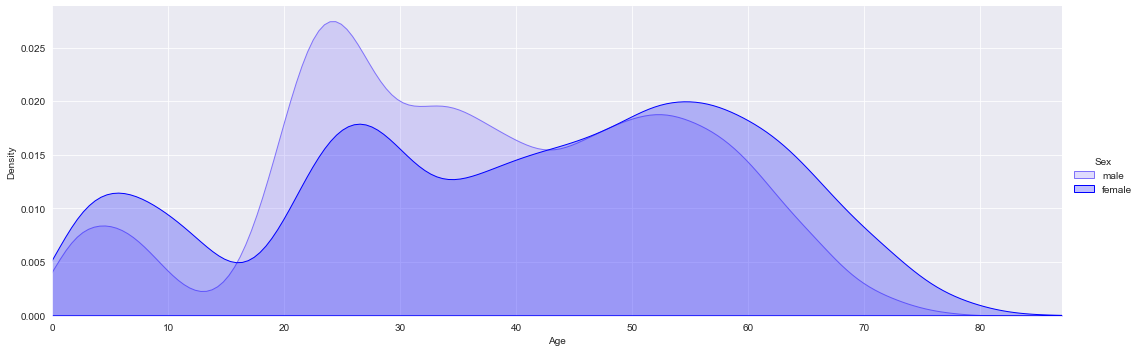

In [193]:
age_mf = sns.FacetGrid(data, hue='Sex', aspect=3, height=5)
age_mf.map(sns.kdeplot, 'Age', shade=True)
max_age = data['Age'].max()
age_mf.set(xlim=(0, max_age))
age_mf.add_legend()

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [ ]:
## Изучите функции "класс пассажира" и "посадка". Какой класс был "самым безопасным"? 
## Существует ли какая-либо связь между портом посадки и выживанием? Предоставьте соответствующие визуализации

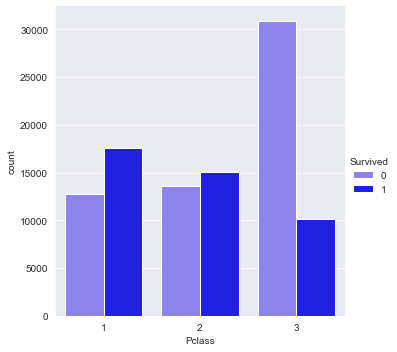

In [195]:
# выживаемость в зависимости от класса
#для визуализации разброса внутри категорий, лучше использовать catplot()
sns.catplot(x = 'Pclass',data=data, hue='Survived', kind = 'count')


вывод Если у тебя 1 класс у тебя больше шанс выжить, чем у того кто в 3 классе

бедность также влияет на выживаемость:

каюты бедняков были на самом дне(первые,кого подтапливало),не уcпели выбрaться, в отличии от кают богачей,которые были наверху

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

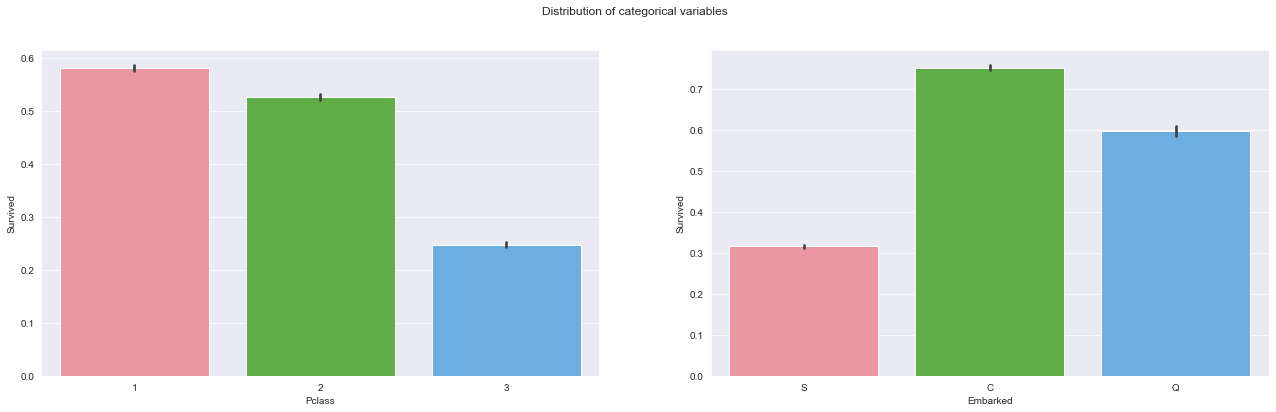

In [200]:
fig, axes = plt.subplots(1, 2, figsize=(22,6))
fig.suptitle('Distribution of categorical variables')
sns.barplot(x = 'Pclass', y = 'Survived', data = data, ax=axes[0])
sns.barplot(x = 'Embarked', y = 'Survived', data = data, ax=axes[1])

Embarked -  порт погрузки:Большинство людей, которые грузились в Southampton, не выжили. 
Большинство людей, которые грузились в Cherbourg, выжили.

Если ты богатая женщина из 1 класса, от 40 до 60 лет, севшая в Порте Cherbourg,шанс выжить еще больше велик на Synthanic

"Значительную часть новых пассажиров составили богатые американцы, закончившие свой зимний сезон в Монте-Карло, Ницце, Канне и других курортах Ривьеры" - выдержка из истории про корабль

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [202]:
## your code
# кол - во пустых ячеек в %
missing_percentages_train = (data[data.columns].isnull().sum() / data.shape[0]) * 100
missing_percentages_train

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Получаем, что в столбце Ticket 4623 (4.62%) пропусков, Age 3292 (3.29%) пропусков,Embarked 250(0.25%), а в Cabin 67866 (67.86%), что сильно больше половины.
Т.к колонка Cabin больше чем на половину пуста, удаляем ее

заполняем пропущенные значения для категориальных переменных самым частым значением в колонке

заполняем пропущенные значения для колличественных переменных медианной по столбцу

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [309]:
y = data['Survived']
X = data.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Pclass', 'Sex', 'Embarked']

def prepare(num_features, cat_features):
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))])

    return ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_features),
            ('cat', categorical_transformer, cat_features)])

log_reg = Pipeline([
    ('prepare', prepare(num_features, cat_features)),
    ('classifier', LogisticRegression(solver='liblinear', penalty='l1'))])

print(f"Точность модели логистической регрессии: \
{cross_validate(log_reg, X, y, cv=5, scoring='accuracy')['test_score'].mean()}")

knn_model = Pipeline([
    ('prepare', prepare(num_features, cat_features)),
    ('classifier', KNeighborsClassifier(n_neighbors=12))])

print(f"Точность модели KNN: {cross_validate(knn_model, X, y, cv=5, scoring='accuracy')['test_score'].mean()}")

Точность модели логистической регрессии: 0.7641899999999999
Точность модели KNN: 0.7571599999999998


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [314]:
## your code
knn_model = Pipeline([
    ('prepare', prepare(num_features, cat_features)),
    ('polynomial', PolynomialFeatures(degree=2)),
    ('selector', SelectFromModel(LogisticRegression(solver='liblinear', penalty='l1', C=0.1))),
    ('classifier', KNeighborsClassifier(n_neighbors=12))])

print(f"Точность модели KNN: {cross_validate(knn_model, X, y, cv=5, scoring='accuracy')['test_score'].mean()}")

Точность модели KNN: 0.7567100000000001


In [316]:
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Cabin']

log_reg = Pipeline([
    ('prepare', prepare(num_features, cat_features)),
    ('polynomial', PolynomialFeatures(degree=2)),
    ('selector', SelectFromModel(LogisticRegression(solver='liblinear', penalty='l1', C=0.1))), 
    ('classifier', LogisticRegression(solver='liblinear', penalty='l1'))])

print(f"Точность логистической регрессии с полиномиальным признаком: \
{cross_validate(log_reg, X, y, cv=5, scoring='accuracy')['test_score'].mean()}")

Точность логистической регрессии с полиномиальным признаком: 0.7668100000000001


Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [ ]:
test_data = pd.read_csv(os.path.join(PATH,  'test.csv')).set_index('PassengerId')
X_test = test_data.drop(['Name', 'Ticket'], axis=1)
X_test['Cabin'] = X_test['Cabin'].fillna(0).apply(lambda x: 1 if (x != 0) else 0)
y_pred = knn_model.fit(X, y).predict(X_test)
result = pd.DataFrame({'PassengerId': test_data.index, 'Survived': y_pred})
result.to_csv('Kate_submission_titanic.csv', index=False)